# MonReader
---
## Summary

**Data Description:**

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

**Goal(s):**

Predict if the page is being flipped using a single image.

**Success Metrics:**

Evaluate model performance based on F1 score, the higher the better.

**Bonus(es):**

Predict if a given sequence of images contains an action of flipping.


# Setup

## Import Libraries

In [19]:
# Standards
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
import statistics
import tensorflow as tf

# For Data Import
from pathlib import Path
from collections import defaultdict

# For Model
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from sklearn.metrics import classification_report
from keras import backend as K

# For Prediction Model
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.metrics import Precision, Recall, AUC
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.sequence import pad_sequences


# Warnings
import warnings

# Suppress deprecation warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=UserWarning)

## Import Data

Image data should be preprocessed before feeding into a computer vision model. Here, we've included normalization and resizing of the data.

In [2]:
# Define the pre-processing functions
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

# Get image paths and labels for training and testing datasets
def get_image_paths_and_labels(directory):
    flip_image_paths = [str(path) for path in list(Path(directory + '/flip').glob('*.jpg'))]
    notflip_image_paths = [str(path) for path in list(Path(directory + '/notflip').glob('*.jpg'))]
    flip_labels = [1]*len(flip_image_paths)
    notflip_labels = [0]*len(notflip_image_paths)
    return flip_image_paths + notflip_image_paths, flip_labels + notflip_labels

# Folder paths
training_folder_path = r"C:\ref\images\training"
testing_folder_path = r"C:\ref\images\testing"


train_image_paths, train_image_labels = get_image_paths_and_labels(training_folder_path)
test_image_paths, test_image_labels = get_image_paths_and_labels(testing_folder_path)

batch_size = 32 # Define batch size

# Create Datasets
train_path_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
train_image_label_ds = train_path_ds.map(load_and_preprocess_from_path_label)
train_ds = train_image_label_ds.shuffle(buffer_size=len(train_image_labels)).batch(batch_size)

test_path_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_image_labels))
test_image_label_ds = test_path_ds.map(load_and_preprocess_from_path_label)
test_ds = test_image_label_ds.shuffle(buffer_size=len(test_image_labels)).batch(batch_size)


# Data Exploration

In [3]:
# Create functions that validate that the files are as expected.

def check_filenames(folder):
    """
    Check if all filenames in a folder follow the expected format: VideoID_FrameNumber.jpg
    """
    for root, _, files in os.walk(folder):
        for file in files:
            if not re.fullmatch(r'\d+_\d+\.jpg', file):
                print(f'Unexpected filename format: {os.path.join(root, file)}')


def count_files_in_folders(main_folder):
    """
    Count files in each subfolder within the main folder.
    """
    for folder_name in ['flip', 'notflip']:
        folder_path = os.path.join(main_folder, folder_name)
        
        if os.path.exists(folder_path):
            num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            print(f"Number of files in '{folder_name}' subfolder: {num_files}")
        else:
            print(f"'{folder_path}' does not exist.")

# Check filenames in training and validation folders
# No output is good
print("Filename validation check:")
check_filenames(training_folder_path)
check_filenames(testing_folder_path)
print("-------------")

# Check the number of files in 'flip' and 'notflip' subfolders in training and validation folders
print("File count validation check:")
print(f"{training_folder_path}")
count_files_in_folders(training_folder_path)
print(f"{testing_folder_path}")
count_files_in_folders(testing_folder_path)
print("-------------")

Filename validation check:
-------------
File count validation check:
C:\ref\images\training
Number of files in 'flip' subfolder: 1162
Number of files in 'notflip' subfolder: 1230
C:\ref\images\testing
Number of files in 'flip' subfolder: 290
Number of files in 'notflip' subfolder: 307
-------------


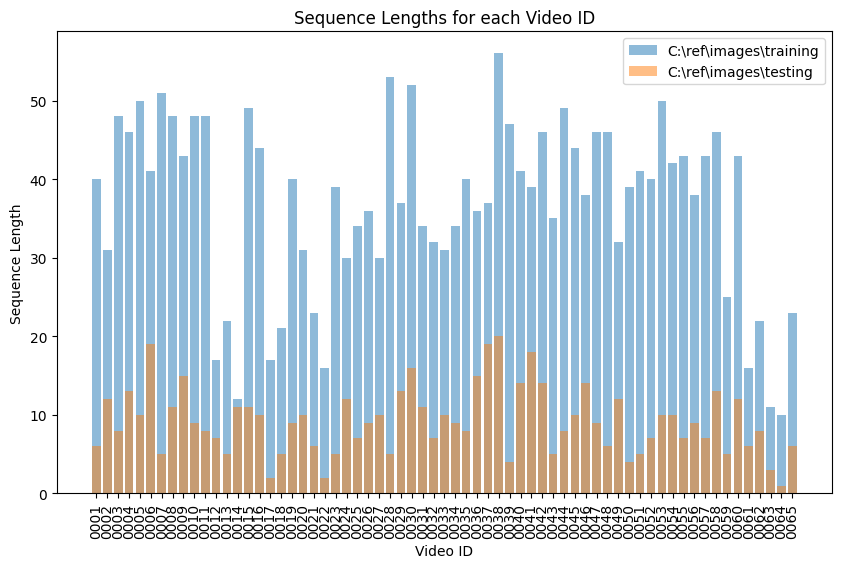

In [4]:
# Sum sequence lengths for all video IDs in a given folder
def check_sequence_lengths(base_folder):
    """Check sequence lengths for all video IDs and return their sum."""
    # Create a dictionary to hold the number of frames for each video ID
    video_lengths = defaultdict(int)
    
    labels = ['flip', 'notflip']  # Define the labels
    for label in labels:  # Iterate over each label
        folder = os.path.join(base_folder, label)  # Form the complete path
        files = os.listdir(folder)
        
        # Count the number of frames for each video
        for file in files:
            video_id, _ = os.path.splitext(file)[0].split("_")
            video_lengths[video_id] += 1
            
    # Sum the lengths of all videos
    total_length = sum(video_lengths.values())
    
    return video_lengths, total_length

# Check the length of each video
def plot_sequence_lengths(folders):
    """Check sequence lengths for all video IDs in multiple folders and plot them."""
    plt.figure(figsize=(10, 6))
    
    for folder in folders:
        video_lengths, _ = check_sequence_lengths(folder)
        
        # Plot the sequence lengths for this folder
        plt.bar(video_lengths.keys(), video_lengths.values(), alpha=0.5, label=folder)

    plt.xlabel('Video ID')
    plt.ylabel('Sequence Length')
    plt.title('Sequence Lengths for each Video ID')
    plt.xticks(rotation=90)  # Rotate the x-axis labels for readability
    plt.legend()  # Add a legend to differentiate between folders
    plt.show()

plot_sequence_lengths([training_folder_path, testing_folder_path])

### Observations

- The sequence lengths vary from video to video. This means that not every video is the same length, and thus we are testing and training on variable amounts of information per video. This will need to be considered when predicting if a given sequence of images contains a flip.
- In general, the video lengths in the testing set are shorter than in the training set. 

# Modelling

## General

### Setup

In [5]:
# Define a CNN model

model = Sequential() # Base liner layer model
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3))) # 1st layer
model.add(MaxPooling2D((2, 2))) # Reduce size of convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu')) # 2nd layer
model.add(MaxPooling2D((2, 2))) # Reduce size of convolutional layer
model.add(Flatten()) # Convert to vector for dense layers
model.add(Dense(64, activation='relu')) # 3rd layer - dense
model.add(Dense(1, activation='sigmoid')) # Output Binary layer: flip or not flip


### Evaluation

In [6]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

# fit the model
history = model.fit(train_ds, epochs=5, validation_data=test_ds)

# evaluate the model
loss, accuracy, precision, recall, f1_score = model.evaluate(test_ds)


Epoch 1/5
75/75 [==============================] - 97s 1s/step - loss: 0.5389 - accuracy: 0.7412 - precision_m: 0.7862 - recall_m: 0.7130 - f1_m: 0.7034 - val_loss: 0.2816 - val_accuracy: 0.8827 - val_precision_m: 0.8019 - val_recall_m: 1.0000 - val_f1_m: 0.8867
Epoch 2/5
75/75 [==============================] - 95s 1s/step - loss: 0.1228 - accuracy: 0.9540 - precision_m: 0.9582 - recall_m: 0.9509 - f1_m: 0.9515 - val_loss: 0.1078 - val_accuracy: 0.9598 - val_precision_m: 0.9290 - val_recall_m: 0.9929 - val_f1_m: 0.9586
Epoch 3/5
75/75 [==============================] - 96s 1s/step - loss: 0.0352 - accuracy: 0.9916 - precision_m: 0.9903 - recall_m: 0.9929 - f1_m: 0.9913 - val_loss: 0.0377 - val_accuracy: 0.9883 - val_precision_m: 0.9843 - val_recall_m: 0.9936 - val_f1_m: 0.9886
Epoch 4/5
75/75 [==============================] - 100s 1s/step - loss: 0.0136 - accuracy: 0.9967 - precision_m: 0.9960 - recall_m: 0.9976 - f1_m: 0.9966 - val_loss: 0.0441 - val_accuracy: 0.9899 - val_precision

### Summary

We find that a general CNN prediction model scores highly for all metrics including accuracy, precision, recall, and F1 score.

# Prediction

Here, we will address the bonus part of the problem: *'predict if a given sequence of images contains an action of flipping'*.

This task is more complex than image classification for a couple of reasons. First, the model now has to understand the time-relationship between images in a sequence. Second, the model also has to be able to understand the concept of the "flipping" action, which involves more than just the static content of a single image.

For these reasons, we will look at using a Long Short-Term Memory (LSTM) network to analyze the sequence of images and predict if a page flip action is occurring. 

In [30]:
def gather_files_by_id(path):
    files_dict = {}
    for root, _, files in os.walk(path):
        for file in files:
            video_id = file.split('_')[0]
            if video_id not in files_dict:
                files_dict[video_id] = []
            files_dict[video_id].append(os.path.join(root, file))
    return files_dict

files_dict = gather_files_by_id(r"C:\ref\images")

for video_id, file_paths in files_dict.items():
    files_dict[video_id] = sorted(file_paths, key=lambda x: int(x.split('_')[1].split('.')[0]))

print(f"Number of videos: {len(files_dict)}")


Number of videos: 65
